# Subgroup Robustness Grows on Trees (Trees - Adult)
In this notebook, we (empirically) investigate the different trees produced by three tree ensemble methods and evaluate
their *individual* performance on groups in the data. In particular, we investigate the trees constructed by:
1. Random Forests
2. Gradient-boosted Trees (`sklearn`)
3. Gradient-boosted Trees (`XGBoost`)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle
import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [2]:
# Cross-validation has been done, you can just load the .pkl files
LOAD_DATA = True

## Datasets Overview
We'll run experiments on four datasets typically used in the fairness and robustness literature:

1. ACS Income (*large*). $n = 499,350$ examples, $20$ features, sensitive groups: *Race* and *Sex*.
2. ACS Employment (*large*). $n = 376,035$ examples, $17$ features, sensitive groups: *Race* and *Sex*. 
3. Adult (*medium*) $n = 48,845$ examples, $14$ features, sensitive groups: *Race* and *Sex*.
4. Communities and Crime (*small*) $n = 1,994$ examples, $113$ features, sensitive groups: *Income Level* and *Race.*

We also plan to do experiments with a fifth synthetic dataset that has overlapping group structure.

# Adult Dataset (Overlapping Groups)
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [3]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


Traditionally, there are $|\mathcal{G}| = 4$ groups in Adult: *(White, Male), (NotWhite, Male), (White, Female),* and *(NotWhite, Female)*.

In this notebook, we will instead do the following group structure for Adult:
- Overlapping groups (make *White* and *NotWhite* their own groups, make *Male* and *Female* their own groups).


In [4]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [5]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


# Utility Code for Parameter Searching
Just some code to make things easier.

In [8]:
# Utilities for fitting  and evaluating models
from sklearn.model_selection import cross_val_predict, GridSearchCV
from joblib import Parallel, delayed

'''
Function for training a model ERM on some KFold splits and then evaluating on
each group for each of the splits.
'''
def split_and_eval(X, y, model, transformer, group_memberships, num_groups, train_size):
    splits = train_test_split(*tuple([X, y] + group_memberships), train_size=train_size)
    X_train = splits[0]
    X_test = splits[1]
    y_train = splits[2]
    y_test = splits[3]

    group_train = splits[4::2]
    group_test = splits[5::2]
    model.fit(transformer.transform(X_train), y_train)

    # Evaluate on all groups
    yhats = {}
    test_errs = {}
    for g in range(num_groups):
        yhats[g] = model.predict(transformer.transform(X_test))
        test_errs[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])        
    
    return yhats, test_errs

def paralell_split_eval(X, y, model, transformer, group_memberships, num_groups, train_size, n_splits, n_jobs=-1):
    parallel = Parallel(n_jobs=n_jobs)
    results = parallel(
        delayed(split_and_eval)(X, y, model, transformer, group_memberships, 
                                num_groups, train_size
        )
        for split in range(n_splits)
    )

    mean_test_errs = {}
    std_errs = {}
    for g in range(num_groups):
        test_errs_g = [test_errs[g] for _, test_errs in results]
        mean_test_errs[g] = np.mean(test_errs_g)
        std_errs[g] = np.sqrt( np.var(test_errs_g) ) / n_splits

    return mean_test_errs, std_errs

# Fit Random Forests
First, we fit `sklearn` Random Forests to the dataset, over a hyperparameter sweep on following parameters:
1. `n_estimators`: the number of trees total in the forest.
2. `max_depth`: the maximum depth of the tree, an `int`. 
3. `min_samples_split`: the minimum number of samples required to split at an internal node. if the number of samples at a node is *less than* `min_samples_split`, we
that node becomes a leaf node.
4. `ccp_alpha`: the complexity parameter used in Minimal Cost-Complexity Pruning. for nonzero values, pruning is performed.

The parameter sweep is linear (unparallelized); the cross-validation is parallelized.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

In [13]:
# Hyperparameter sweep for RF
n_estimators_params = [8, 16, 32, 64, 128, 256]
if LOAD_DATA:
    with open('adult_trees_params/best_rf_params_avg.pkl', 'rb') as handle:
        best_rf_params_avg = pickle.load(handle)
    with open('adult_trees_params/best_rf_params_worstgp.pkl', 'rb') as handle:
        best_rf_params_worstgp = pickle.load(handle)

    print(best_rf_params_avg)
    print(best_rf_params_worstgp)
    print("Average and worst group are the same? {}".format(best_rf_params_avg == best_rf_params_worstgp))
else:
    n_estimators_params = [8, 16, 32, 64, 128, 256]
    grid = {
        'max_depth': [2, 4, 8, 16, None],
        'ccp_alpha': [0., 0.001, 0.01, 0.1],
        'random_state': [0]
    }

    param_grid = list(ParameterGrid(grid))
    print("Fitting {} models total...".format(len(param_grid) * len(n_estimators_params)))
    best_rf_params_avg = {}
    best_rf_params_worstgp = {}
    for n_estimators in n_estimators_params:
        best_avg_err = np.Inf
        best_worstgp_err = np.Inf
        for params in param_grid:
            params['n_estimators'] = n_estimators
            rf_model = RandomForestClassifier(**params)
            start = time.time()
            mean_test_errs, _ = paralell_split_eval(X, y, rf_model, col_transf, group_memberships, num_groups, train_size=0.8, n_splits=5, n_jobs=5)
            end = time.time()
            print("Cross-validated RandomForestClassifier ({}) in {} seconds.".format(params, end - start))

            avg_err = mean_test_errs[0]
            worstgp_err = max(mean_test_errs.values())
            print("\tAverage Error: {}".format(avg_err))
            print("\tWorst-group Error: {}".format(worstgp_err))

            if avg_err < best_avg_err:
                best_avg_err = avg_err
                best_rf_params_avg[n_estimators] = params.copy()
            if worstgp_err < best_worstgp_err:
                best_worstgp_err = worstgp_err
                best_rf_params_worstgp[n_estimators] = params.copy()

    # Save the best parameters to not have to cross-validate again
    print(best_rf_params_avg)
    print(best_rf_params_worstgp)

    # Save to pickle files
    with open('adult_trees_params/best_rf_params_avg.pkl', 'wb') as handle:
        pickle.dump(best_rf_params_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('adult_trees_params/best_rf_params_worstgp.pkl', 'wb') as handle:
        pickle.dump(best_rf_params_worstgp, handle, protocol=pickle.HIGHEST_PROTOCOL)

{8: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}, 16: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 16}, 32: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 32}, 64: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 64}, 128: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 128}, 256: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 256}}
{8: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 8}, 16: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 16}, 32: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 32}, 64: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 64}, 128: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 128}, 256: {'ccp_alpha': 0.0, 'max_depth': 16, 'random_state': 0, 'n_estimators': 256}}
Average and worst group are the sa

In [14]:
# Refit the best estimators (worst-group and average accuracy)
best_rfs_avg = {}
overall_avg_accs = list()
best_rfs_worstgp = {}
overall_worstgp_accs = list()

for n_estimators in n_estimators_params:
    rf_model_avg = RandomForestClassifier(**best_rf_params_avg[n_estimators])
    rf_model_avg.fit(col_transf.transform(X_train), y_train)
    rf_model_worstgp = RandomForestClassifier(**best_rf_params_worstgp[n_estimators])
    rf_model_worstgp.fit(col_transf.transform(X_train), y_train)

    print("n_estimators: {}".format(n_estimators))
    avg_acc = accuracy_score(rf_model_avg.predict(col_transf.transform(X_test)), y_test)
    print("\tAverage accuracy (RF-avg, {} estimators): {}".format(n_estimators, avg_acc))
    yhats = rf_model_avg.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])
    worstgp_acc = 1 - worstgp_err
    print("\tWorst-group accuracy (RF-avg, {} estimators): {}".format(n_estimators, worstgp_acc))

    print("\tAverage accuracy (RF-worstgp, {} estimators): {}".format(n_estimators, accuracy_score(rf_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
    yhats = rf_model_worstgp.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])    
    print("\tWorst-group accuracy (RF-worstgp, {} estimators): {}".format(n_estimators, 1 - worstgp_err))

    best_rfs_avg[n_estimators] = rf_model_avg
    best_rfs_worstgp[n_estimators] = rf_model_worstgp

    overall_avg_accs.append(avg_acc)
    overall_worstgp_accs.append(worstgp_acc)

n_estimators: 8
	Average accuracy (RF-avg, 8 estimators): 0.8582642343836374
	Worst-group accuracy (RF-avg, 8 estimators): 0.8177958279490493
	Average accuracy (RF-worstgp, 8 estimators): 0.8582642343836374
	Worst-group accuracy (RF-worstgp, 8 estimators): 0.8177958279490493
n_estimators: 16
	Average accuracy (RF-avg, 16 estimators): 0.8576008844665561
	Worst-group accuracy (RF-avg, 16 estimators): 0.815211371607901
	Average accuracy (RF-worstgp, 16 estimators): 0.8576008844665561
	Worst-group accuracy (RF-worstgp, 16 estimators): 0.815211371607901
n_estimators: 32
	Average accuracy (RF-avg, 32 estimators): 0.8581536760641238
	Worst-group accuracy (RF-avg, 32 estimators): 0.815211371607901
	Average accuracy (RF-worstgp, 32 estimators): 0.8581536760641238
	Worst-group accuracy (RF-worstgp, 32 estimators): 0.815211371607901
n_estimators: 64
	Average accuracy (RF-avg, 64 estimators): 0.8603648424543947
	Worst-group accuracy (RF-avg, 64 estimators): 0.8176112239246816
	Average accuracy (RF

In [15]:
# For each group, evaluate tree models on the group:
# - variance per group
# - tree model that's best for the group
rf_test_errs = {}                       # n_estimators: test errors per group
rf_test_vars = {}
rf_test_ranges = {}
rf_test_mins = {}
for n_estimators in n_estimators_params:
    test_errs = {}
    rf_model = best_rfs_worstgp[n_estimators]
    rf_trees = list(rf_model.estimators_)
    rf_test_vars[n_estimators] = {}
    rf_test_ranges[n_estimators] = {}
    rf_test_mins[n_estimators] = {}
    for g in range(num_groups):
        test_errs[g] = []
        for tree in rf_trees:
            yhats = tree.predict(col_transf.transform(X_test))
            test_errs[g].append(np.mean(y_test[group_test[g]] != yhats[group_test[g]]))
        rf_test_vars[n_estimators][g] = np.var(test_errs[g])
        rf_test_ranges[n_estimators][g] = np.max(test_errs[g]) - np.min(test_errs[g])
        rf_test_mins[n_estimators][g] = np.min(test_errs[g])

    rf_test_errs[n_estimators] = test_errs

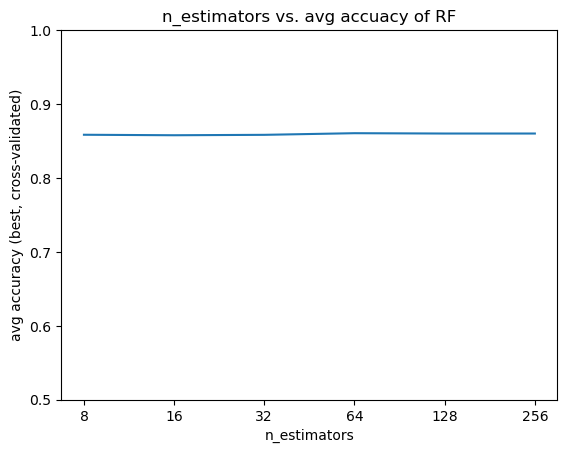

In [16]:
# Plot average accuracy as a function of n_estimators
plot_x_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
ax.plot(plot_x, overall_avg_accs)
ax.set_xticks(plot_x, plot_x_labels)
ax.set_ylim(0.5, 1)

ax.set_xlabel("n_estimators")
ax.set_ylabel("avg accuracy (best, cross-validated)")
ax.set_title("n_estimators vs. avg accuacy of RF")
plt.show()

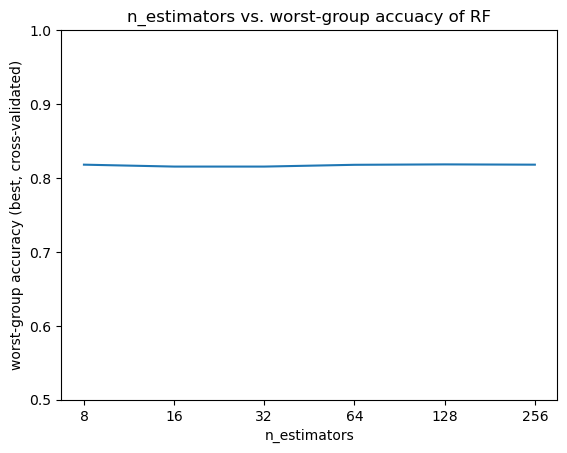

In [17]:
# Plot worst-group accuracy as a function of n_estimators
plot_x_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
ax.plot(plot_x, overall_worstgp_accs)
ax.set_xticks(plot_x, plot_x_labels)
ax.set_ylim(0.5, 1)

ax.set_xlabel("n_estimators")
ax.set_ylabel("worst-group accuracy (best, cross-validated)")
ax.set_title("n_estimators vs. worst-group accuacy of RF")
plt.show()

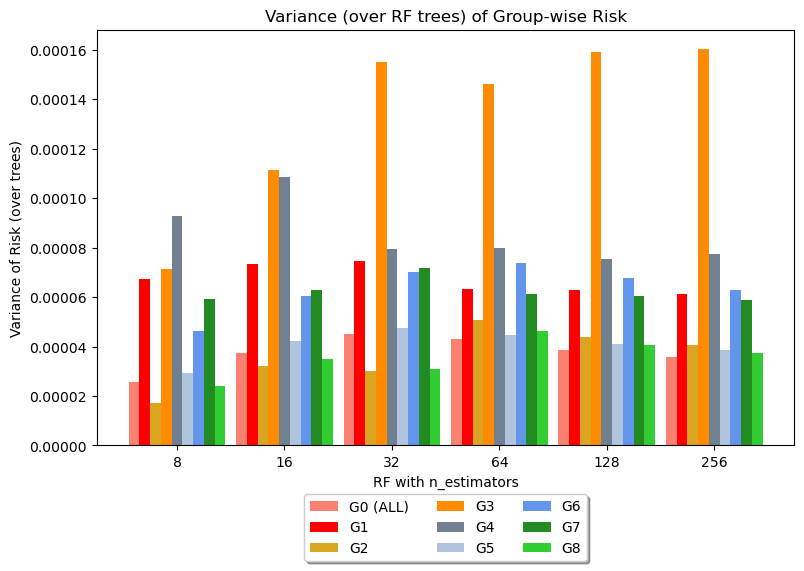

In [18]:
# Plot the variances (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_vars[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_vars[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_vars[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_vars[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_vars[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_vars[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_vars[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_vars[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_vars[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Variance of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Variance (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

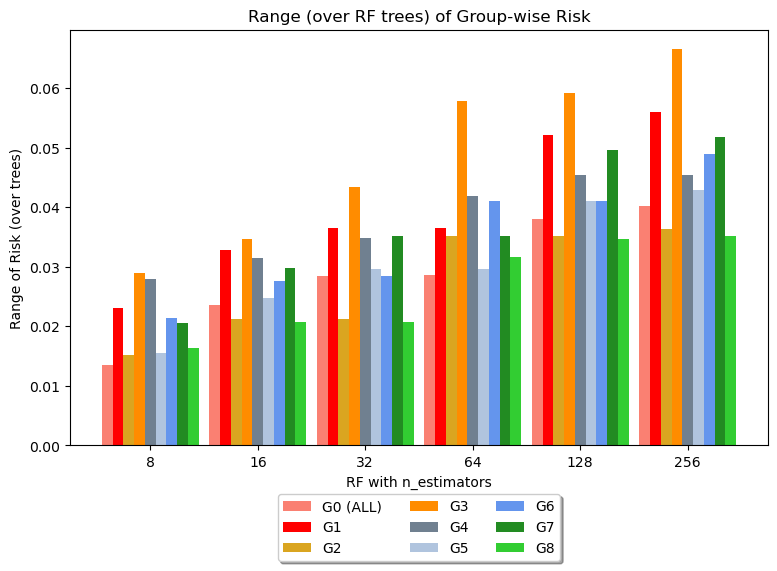

In [19]:
# Plot the ranges (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_ranges[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_ranges[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_ranges[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_ranges[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_ranges[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_ranges[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_ranges[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_ranges[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_ranges[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Range of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Range (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

In [20]:
# Baseline Decision Tree with max_depth=16
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=16, random_state=0)
dtree.fit(col_transf.transform(X_train), y_train)
for g in range(num_groups):
    yhats = tree.predict(col_transf.transform(X_test))
    print("Decision Tree (max_depth=16) error for group {}: {}".format(g, np.mean(y_test[group_test[g]] != yhats[group_test[g]])))

Decision Tree (max_depth=16) error for group 0: 0.17600884466556108
Decision Tree (max_depth=16) error for group 1: 0.2182019568026583
Decision Tree (max_depth=16) error for group 2: 0.10198899703766398
Decision Tree (max_depth=16) error for group 3: 0.18352601156069365
Decision Tree (max_depth=16) error for group 4: 0.07329842931937172
Decision Tree (max_depth=16) error for group 5: 0.18290488431876606
Decision Tree (max_depth=16) error for group 6: 0.13359683794466404
Decision Tree (max_depth=16) error for group 7: 0.21427402193485023
Decision Tree (max_depth=16) error for group 8: 0.09638964577656675


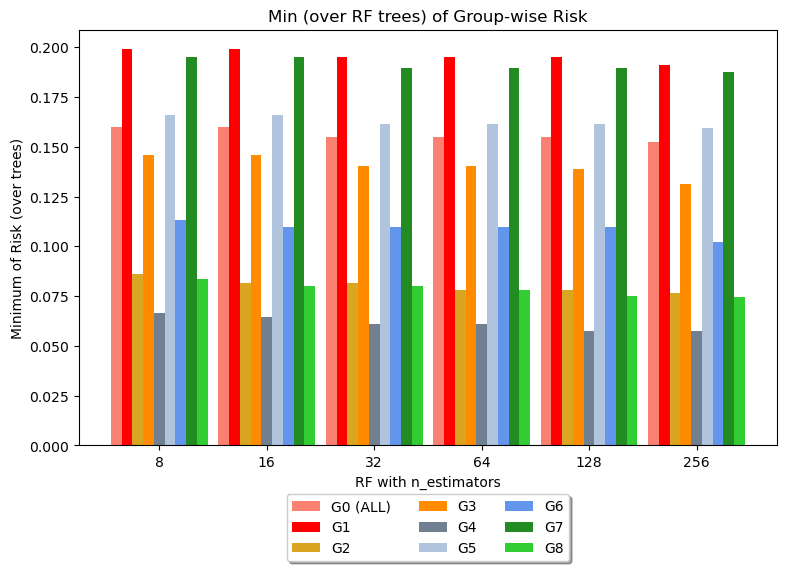

In [21]:
# Plot the min (for each group, across all trees) for each of the RF models
# Compute the variances
plot_group_labels = n_estimators_params
plot_x = np.arange(len(n_estimators_params))
fig, ax = plt.subplots()
bar_width = 0.1

plot_rects1 = ax.bar(plot_x - 4.0*bar_width, [rf_test_mins[n_estimators][0] for n_estimators in n_estimators_params], bar_width, label='G0 (ALL)', color="salmon")
plot_rects2 = ax.bar(plot_x - 3.0*bar_width, [rf_test_mins[n_estimators][1] for n_estimators in n_estimators_params], bar_width, label='G1', color="red")
plot_rects3 = ax.bar(plot_x - 2.0*bar_width, [rf_test_mins[n_estimators][2] for n_estimators in n_estimators_params], bar_width, label='G2', color="goldenrod")
plot_rects4 = ax.bar(plot_x - 1.0*bar_width, [rf_test_mins[n_estimators][3] for n_estimators in n_estimators_params], bar_width, label='G3', color="darkorange")
plot_rects5 = ax.bar(plot_x - 0.0*bar_width, [rf_test_mins[n_estimators][4] for n_estimators in n_estimators_params], bar_width, label='G4', color="slategrey")
plot_rects6 = ax.bar(plot_x + 1.0*bar_width, [rf_test_mins[n_estimators][5] for n_estimators in n_estimators_params], bar_width, label='G5', color="lightsteelblue")
plot_rects7 = ax.bar(plot_x + 2.0*bar_width, [rf_test_mins[n_estimators][6] for n_estimators in n_estimators_params], bar_width, label='G6', color="cornflowerblue")
plot_rects8 = ax.bar(plot_x + 3.0*bar_width, [rf_test_mins[n_estimators][7] for n_estimators in n_estimators_params], bar_width, label='G7', color="forestgreen")
plot_rects9 = ax.bar(plot_x + 4.0*bar_width, [rf_test_mins[n_estimators][8] for n_estimators in n_estimators_params], bar_width, label='G8', color="limegreen")

ax.set_ylabel('Minimum of Risk (over trees)')
ax.set_xlabel('RF with n_estimators')
ax.set_xticks(plot_x, plot_group_labels)
fig.set_size_inches(9., 6.)
ax.set_title("Min (over RF trees) of Group-wise Risk")

# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.show()

[Text(0.6779022517435742, 0.9705882352941176, 'x[44] <= 0.5\ngini = 0.377\nsamples = 22834\nvalue = [27069, 9108]'),
 Text(0.42386958036673833, 0.9117647058823529, 'x[25] <= 0.5\ngini = 0.187\nsamples = 13368\nvalue = [18971, 2213]'),
 Text(0.3220922820951997, 0.8529411764705882, 'x[47] <= 0.5\ngini = 0.126\nsamples = 12125\nvalue = [17899, 1301]'),
 Text(0.23090429372649113, 0.7941176470588235, 'x[100] <= 0.767\ngini = 0.159\nsamples = 8912\nvalue = [12926, 1229]'),
 Text(0.13542716169622068, 0.7352941176470589, 'x[102] <= 0.509\ngini = 0.082\nsamples = 6736\nvalue = [10245, 460]'),
 Text(0.1085759784166219, 0.6764705882352942, 'x[27] <= 0.5\ngini = 0.078\nsamples = 6700\nvalue = [10215, 435]'),
 Text(0.07152012806734731, 0.6176470588235294, 'x[101] <= 0.083\ngini = 0.098\nsamples = 3623\nvalue = [5498, 300]'),
 Text(0.04345222102812108, 0.5588235294117647, 'x[98] <= 0.295\ngini = 0.077\nsamples = 3579\nvalue = [5497, 230]'),
 Text(0.019299659681174995, 0.5, 'x[4] <= 0.5\ngini = 0.05\

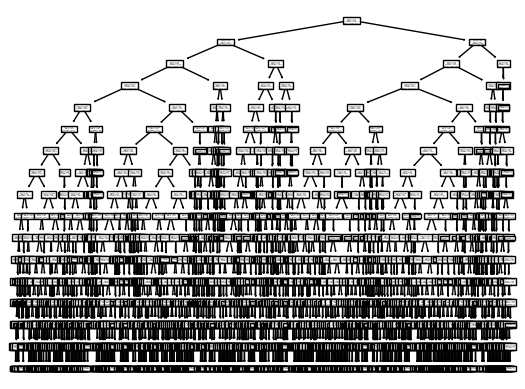

In [25]:
# Check out what some trees in the random forest looks like
from sklearn.tree import plot_tree

print(best_rf_params_worstgp[n_estimators])
n_estimators = 8
NUM_TREE = 0
rf_model = best_rfs_worstgp[n_estimators]
rf_trees = list(rf_model.estimators_)
plot_tree(rf_trees[NUM_TREE])

# Fit Gradient-Boosted Trees
Next, we fit `sklearn` Gradient-Boosted trees to the dataset, over a hyperparameter sweep on following parameters:
1. `n_estimators`: the number of trees total in the forest.
2. `max_depth`: the maximum depth of the tree, an `int`. 
3. `min_samples_split`: the minimum number of samples required to split at an internal node. if the number of samples at a node is *less than* `min_samples_split`, we
that node becomes a leaf node.
4. `ccp_alpha`: the complexity parameter used in Minimal Cost-Complexity Pruning. for nonzero values, pruning is performed.

The parameter sweep is linear (unparallelized); the cross-validation is parallelized.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

: 

In [ ]:
# Hyperparameter sweep for GBM
if LOAD_DATA:
    with open('adult_trees_params/best_gb_params_avg.pkl', 'rb') as handle:
        best_gb_params_avg = pickle.load(handle)
    with open('adult_trees_params/best_gb_params_worstgp.pkl', 'rb') as handle:
        best_gb_params_worstgp = pickle.load(handle)

    print(best_gb_params_avg)
    print(best_gb_params_worstgp)
    print("Average and worst group are the same? {}".format(best_gb_params_avg == best_gb_params_worstgp))

: 

In [186]:
# Refit the best estimators (worst-group and average accuracy)
best_gbs_avg = {}
overall_avg_accs = list()
best_gbs_worstgp = {}
overall_worstgp_accs = list()

for n_estimators in n_estimators_params:
    gb_model_avg = GradientBoostingClassifier(**best_gb_params_avg[n_estimators])
    gb_model_avg.fit(col_transf.transform(X_train), y_train)
    gb_model_worstgp = GradientBoostingClassifier(**best_gb_params_worstgp[n_estimators])
    gb_model_worstgp.fit(col_transf.transform(X_train), y_train)

    print("n_estimators: {}".format(n_estimators))
    avg_acc = accuracy_score(gb_model_avg.predict(col_transf.transform(X_test)), y_test)
    print("\tAverage accuracy (GB-avg, {} estimators): {}".format(n_estimators, avg_acc))
    yhats = gb_model_avg.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])
    worstgp_acc = 1 - worstgp_err
    print("\tWorst-group accuracy (GB-avg, {} estimators): {}".format(n_estimators, worstgp_acc))

    print("\tAverage accuracy (GB-worstgp, {} estimators): {}".format(n_estimators, accuracy_score(gb_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
    yhats = gb_model_worstgp.predict(col_transf.transform(X_test))
    worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])    
    print("\tWorst-group accuracy (GB-worstgp, {} estimators): {}".format(n_estimators, 1 - worstgp_err))

    best_gbs_avg[n_estimators] = gb_model_avg
    best_gbs_worstgp[n_estimators] = gb_model_worstgp

    overall_avg_accs.append(avg_acc)
    overall_worstgp_accs.append(worstgp_acc)

n_estimators: 8
	Average accuracy (GB-avg, 8 estimators): 0.8658927584300719
	Worst-group accuracy (GB-avg, 8 estimators): 0.8264722170943326
	Average accuracy (GB-worstgp, 8 estimators): 0.8658927584300719
	Worst-group accuracy (GB-worstgp, 8 estimators): 0.8264722170943326
n_estimators: 16
	Average accuracy (GB-avg, 16 estimators): 0.8658927584300719
	Worst-group accuracy (GB-avg, 16 estimators): 0.8257338009968618
	Average accuracy (GB-worstgp, 16 estimators): 0.8658927584300719
	Worst-group accuracy (GB-worstgp, 16 estimators): 0.8257338009968618
n_estimators: 32
	Average accuracy (GB-avg, 32 estimators): 0.8679933665008291
	Worst-group accuracy (GB-avg, 32 estimators): 0.8299796935573196
	Average accuracy (GB-worstgp, 32 estimators): 0.8679933665008291
	Worst-group accuracy (GB-worstgp, 32 estimators): 0.8299796935573196
n_estimators: 64
	Average accuracy (GB-avg, 64 estimators): 0.8713101160862355
	Worst-group accuracy (GB-avg, 64 estimators): 0.8327487539228355
	Average accuracy

In [187]:
# For each GB model, record the stage-wise loss (per group)
gb_test_errs = {}   # dict of n_estimators -> group -> errors for each stage
for n_estimators in n_estimators_params:
    gb_test_errs[n_estimators] = {}
    gb_model = best_gbs_worstgp[n_estimators]
    staged_preds = list(gb_model.staged_predict(col_transf.transform(X_test)))
    for g in range(num_groups):
        gb_test_errs[n_estimators][g] = list()
        for stage in range(n_estimators):
            yhats_stage = staged_preds[stage]
            gb_test_errs[n_estimators][g].append(np.mean(y_test[group_test[g]] != yhats_stage[group_test[g]]))

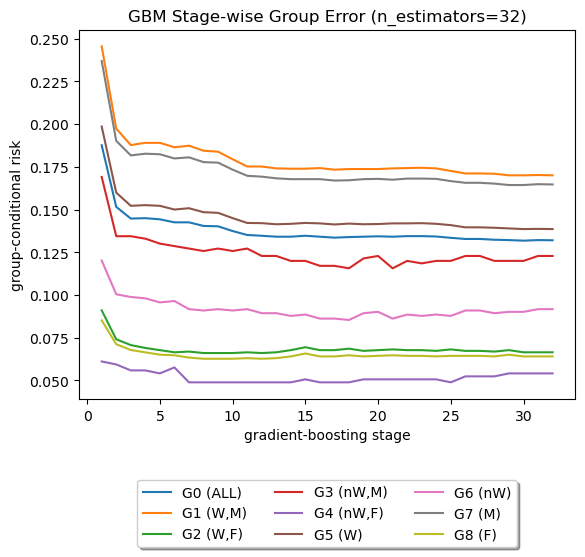

In [188]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = 32
fig, ax = plt.subplots()
group_stagewise_errs = gb_test_errs[N_ESTIMATORS]
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("GBM Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

In [189]:
# Take a look at the stage-wise errors per group
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


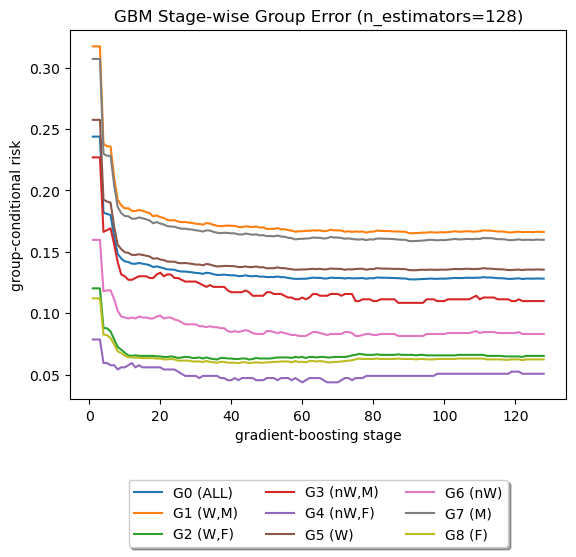

In [190]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = 128
fig, ax = plt.subplots()
group_stagewise_errs = gb_test_errs[N_ESTIMATORS]
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("GBM Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

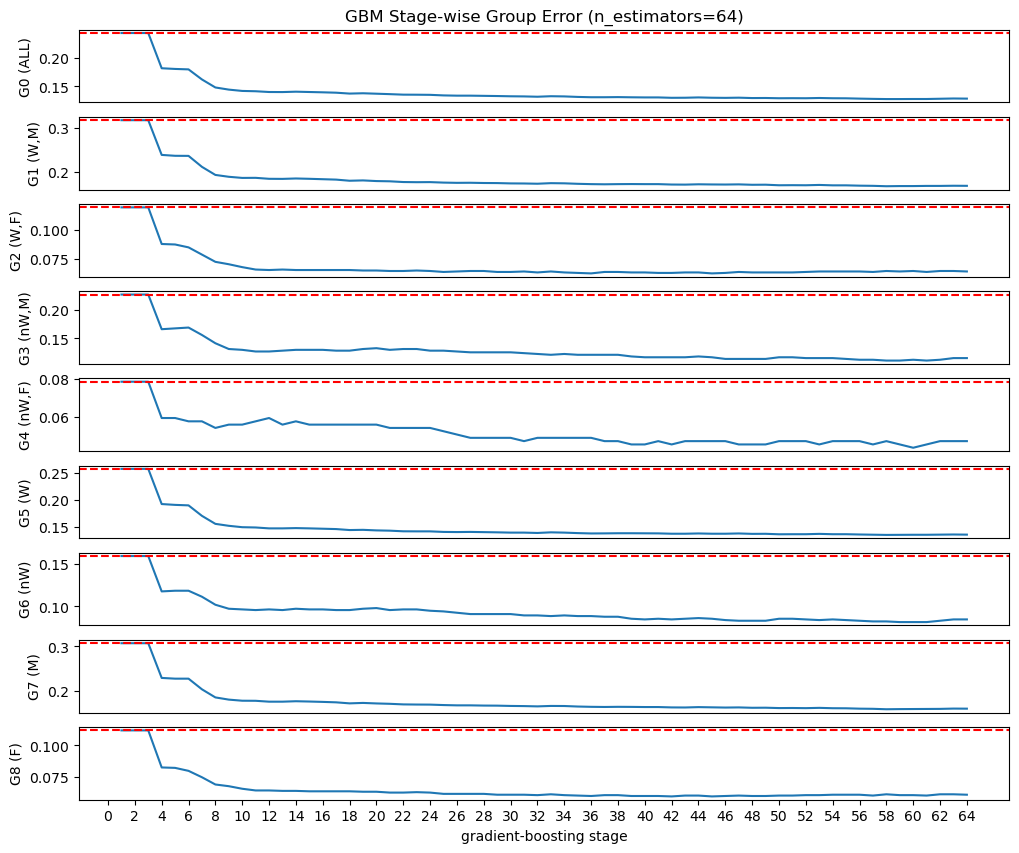

In [191]:
# Group-conditional error of each group for N_ESTIMATORS
N_ESTIMATORS = 64
fig, axs = plt.subplots(9, 1, figsize=(12, 10))
group_stagewise_errs = gb_test_errs[N_ESTIMATORS]

stages = range(1, N_ESTIMATORS+1)
for g in range(num_groups):
    axs[g].plot(stages, group_stagewise_errs[g])
    axs[g].axhline(np.mean(y_test[group_test[g]]), color='r', linestyle='--')
    axs[g].set_xticks([])
    axs[g].set_ylabel("G{} ({})".format(g, group_names[g]))

axs[0].set_title("GBM Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
axs[8].set_xticks(np.arange(0, N_ESTIMATORS+1, step=2))
axs[8].set_xlabel("gradient-boosting stage")
plt.show()

# XGBoost

In [201]:
from xgboost import XGBClassifier

In [202]:
if LOAD_DATA:
    with open('adult_trees_params/best_xgb_params_avg.pkl', 'rb') as handle:
        best_xgb_params_avg = pickle.load(handle)
    with open('adult_trees_params/best_xgb_params_worstgp.pkl', 'rb') as handle:
        best_xgb_params_worstgp = pickle.load(handle)

    print(best_xgb_params_avg)
    print(best_xgb_params_worstgp)
    print("Average and worst group are the same? {}".format(best_xgb_params_avg == best_xgb_params_worstgp))

{'learning_rate': 0.5, 'max_depth': 4, 'random_state': 0}
{'learning_rate': 0.5, 'max_depth': 4, 'random_state': 0}
Average and worst group are the same? True


In [203]:
# Refit the best estimators (worst-group and average accuracy)
best_xgbs_avg = {}
overall_avg_accs = list()
best_xgbs_worstgp = {}
overall_worstgp_accs = list()

xgb_model_avg = XGBClassifier(**best_xgb_params_avg)
xgb_model_avg.fit(col_transf.transform(X_train), y_train)
xgb_model_worstgp = XGBClassifier(**best_xgb_params_worstgp)
xgb_model_worstgp.fit(col_transf.transform(X_train), y_train)

avg_acc = accuracy_score(xgb_model_avg.predict(col_transf.transform(X_test)), y_test)
print("Average accuracy (XGB-avg): {}".format(avg_acc))
yhats = xgb_model_avg.predict(col_transf.transform(X_test))
worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])
worstgp_acc = 1 - worstgp_err
print("Worst-group accuracy (XGB-avg): {}".format(worstgp_acc))

print("Average accuracy (XGB-worstgp): {}".format(accuracy_score(xgb_model_worstgp.predict(col_transf.transform(X_test)), y_test)))
yhats = xgb_model_worstgp.predict(col_transf.transform(X_test))
worstgp_err = np.mean(y_test[group_test[1]] != yhats[group_test[1]])    
print("Worst-group accuracy (XGB-worstgp): {}".format(1 - worstgp_err))

Average accuracy (XGB-avg): 0.8700939745715865
Worst-group accuracy (XGB-avg): 0.8312719217278937
Average accuracy (XGB-worstgp): 0.8700939745715865
Worst-group accuracy (XGB-worstgp): 0.8312719217278937


In [207]:
# Need to do staged_predict manually
# For each XGB model, record the stage-wise loss (per group)
num_stages = xgb_model_avg.get_num_boosting_rounds()
xgb_test_errs = {}   # dict of group -> errors for each stage
xgb_train_errs = {}
staged_preds = list()
staged_preds_train = list()
for stage in range(1, num_stages + 1):
    staged_preds_train.append(xgb_model_avg.predict(col_transf.transform(X_train), iteration_range=(0, stage)))
    staged_preds.append(xgb_model_avg.predict(col_transf.transform(X_test), iteration_range=(0, stage)))

for g in range(num_groups):
    xgb_train_errs[g] = list()
    xgb_test_errs[g] = list()
    for stage in range(num_stages):
        yhats_stage = staged_preds[stage]
        yhats_stage_train = staged_preds_train[stage]
        xgb_train_errs[g].append(np.mean(y_train[group_train[g]] != yhats_stage_train[group_train[g]]))
        xgb_test_errs[g].append(np.mean(y_test[group_test[g]] != yhats_stage[group_test[g]]))

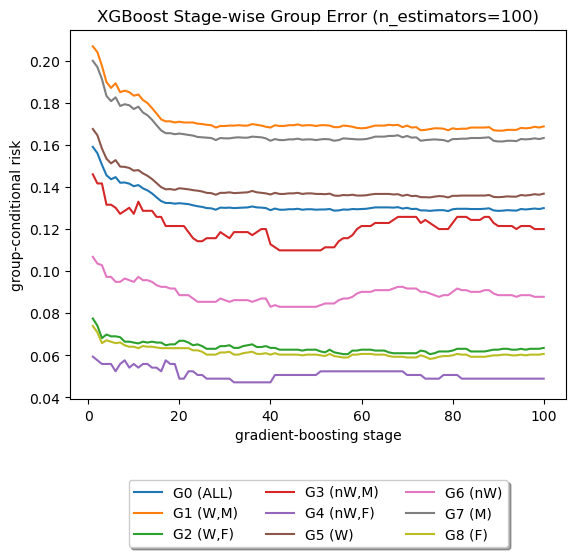

In [205]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_avg.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = xgb_test_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional risk")
ax.set_title("XGBoost Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

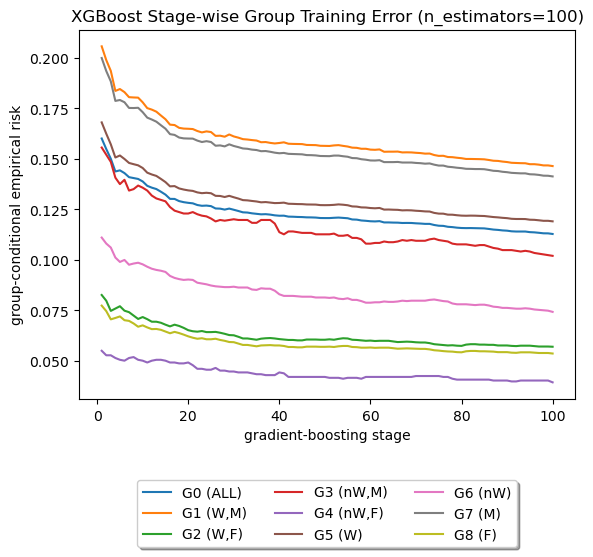

In [211]:
# For each GB model, plot the group-wise errors as a funciton of the stage
N_ESTIMATORS = xgb_model_avg.get_num_boosting_rounds()
fig, ax = plt.subplots()
group_stagewise_errs = xgb_train_errs
for g in range(num_groups):
    stagewise_errs = group_stagewise_errs[g]
    stages = range(1, N_ESTIMATORS+1)
    ax.plot(stages, stagewise_errs, label='G{} ({})'.format(g, group_names[g]))

ax.set_xlabel("gradient-boosting stage")
ax.set_ylabel("group-conditional empirical risk")
ax.set_title("XGBoost Stage-wise Group Training Error (n_estimators={})".format(N_ESTIMATORS))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)

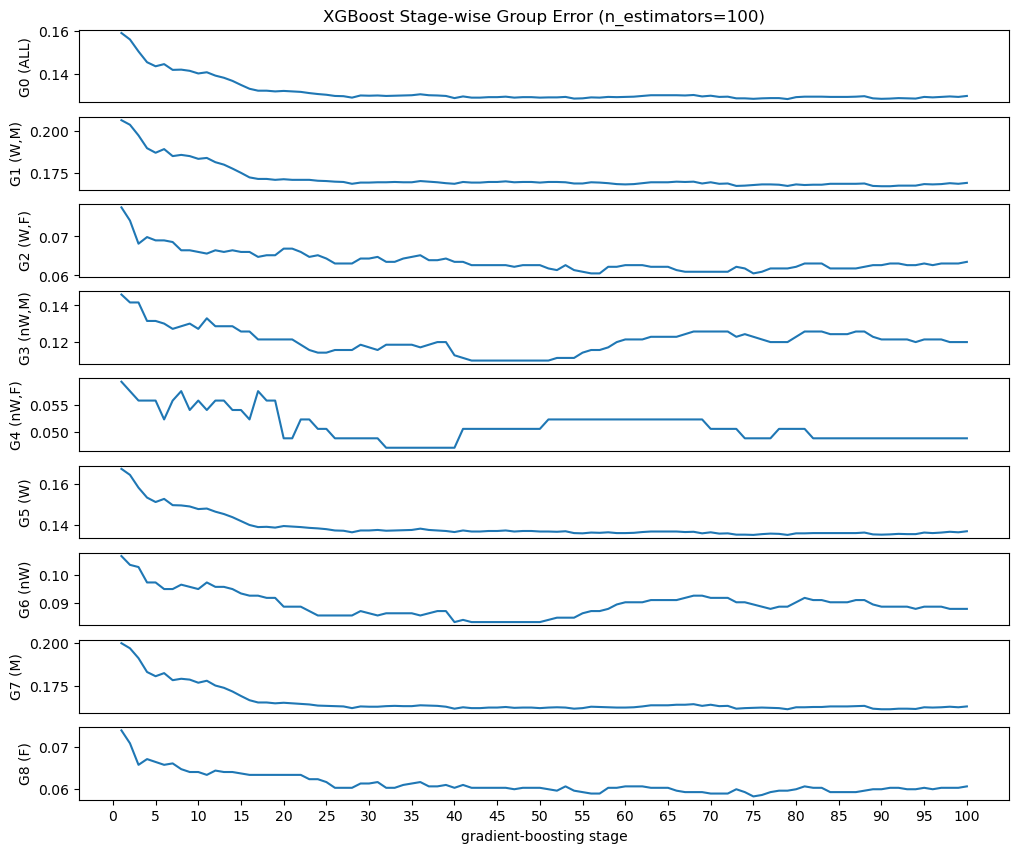

In [206]:
# Group-conditional error of each group for N_ESTIMATORS
fig, axs = plt.subplots(9, 1, figsize=(12, 10))
group_stagewise_errs = xgb_test_errs

stages = range(1, N_ESTIMATORS+1)
for g in range(num_groups):
    axs[g].plot(stages, group_stagewise_errs[g])
    #axs[g].axhline(np.mean(y_test[group_test[g]]), color='r', linestyle='--')
    axs[g].set_xticks([])
    axs[g].set_ylabel("G{} ({})".format(g, group_names[g]))

axs[0].set_title("XGBoost Stage-wise Group Error (n_estimators={})".format(N_ESTIMATORS))
axs[8].set_xticks(np.arange(0, N_ESTIMATORS+1, step=5))
axs[8].set_xlabel("gradient-boosting stage")
plt.show()